In [1]:
%matplotlib inline
import os

import numpy as np 
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sbn

# load the databases
# note that specifying the encoding here was important to getting them to load properly
base_dir = '/Users/dcard/Dropbox/CMU/ARK/terrorism/databases/'
gtd = pd.read_csv(os.path.join(base_dir, 'gtd', 'globalterrorismdb_0617dist.csv'), header=0, encoding='ISO-8859-1', low_memory=False)
rand = pd.read_csv(os.path.join(base_dir, 'RAND', 'RAND_Database_of_Worldwide_Terrorism_Incidents.csv'), header=0, encoding='ISO-8859-1', low_memory=False)
msa = pd.read_csv(os.path.join(base_dir, 'MSA', 'Data', 'Stanford_MSA_Database.csv'), header=0)

/Users/dcard/anaconda/envs/python3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [9]:
# look at a snapshot of the GTD database
pd.set_option('display.max_columns', None)  
gtd.tail()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,nvictims
170345,201612310040,2016,12,31,NaN,0,NaN,146,Niger,11,Sub-Saharan Africa,Diffa,Garoua,13.883032,13.177504,1.0,0,NaN,12/31/2016: Assailants attacked military posit...,1,1,0,1,1.0,Insurgency/Guerilla Action,0,1,0,9,Unknown,NaN,NaN,NaN,NaN,4,Military,34.0,"Military Personnel (soldiers, troops, officers...",Niger Army,Soldiers,146.0,Niger,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boko Haram,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,-99.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,0.0,12.0,7.0,0.0,0.0,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""15 soldiers killed, 19 injured in Niger terro...","""Niger: Boko Haram attack kills two soldiers i...",NaN,START Primary Collection,1,1,0,1,NaN,22.0
170346,201612310042,2016,12,31,NaN,0,NaN,160,Philippines,5,Southeast Asia,Maguindanao,Talitay,7.027067,124.386552,1.0,0,NaN,12/31/2016: An explosive device detonated targ...,1,1,1,0,NaN,NaN,0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,12,NGO,NaN,NaN,Unknown,Convoy of Relief Workers,160.0,Philippines,4.0,Military,4.0,Multinational Corporation,Armed Forces of the Philippines (AFP),Convoy,160.0,Philippines,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,-99.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,Explosives/Bombs/Dynamite,16.0,Unknown Explosive Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A roadside bomb was used in the attack.,0.0,0.0,0.0,0.0,0.0,0.0,-9,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""AFP braces for more BIFF attacks in ARMM,"" Ma...","""Asia: US Army ASD Philippine Terrorist Media ...",NaN,START Primary Collection,-9,-9,0,-9,NaN,0.0
170347,201612310043,2016,12,31,NaN,1,NaN,229,Democratic Republic of the Congo,11,Sub-Saharan Africa,Bas-Uele,Nakolongbo,4.308611,25.091389,2.0,0,NaN,12/31/2016: Assailants attacked a village and ...,1,1,1,0,NaN,NaN,0,1,0,6,Hostage Taking (Kidnapping),NaN,NaN,NaN,NaN,14,Private Citizens & Property,75.0,Village/City/Town/Suburb,Nakolongbo Village,Village,229.0,Democratic Republic of the Congo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lord's Resistance Army (LRA),NaN,NaN,NaN,NaN,NaN,"The specific motive is unknown; however, sourc...",0.0,NaN,NaN,0,-99.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0,NaN,NaN,NaN,NaN,1.0,33.0,0.0,NaN,8.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,5.0,Successful R

In [14]:
gtd['nvictims'] = gtd['nkill'] + gtd['nwound']

# take US cases only 
us = gtd[gtd.country == 217]
print(us.shape)
us.head(n=2)

# take only cases using firearmes
us = us[(us.weaptype1 == 5) | (us.weaptype2 == 5) | (us.weaptype3 == 5)]
print(us.shape)
us.tail(n=2)


(2758, 136)
(386, 136)


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,nvictims
167665,201610130052,2016,10,13,NaN,0,NaN,217,United States,1,North America,Indiana,Indianapolis,39.826113,-86.227124,1.0,0,NaN,10/13/2016: An assailant opened fire on the In...,1,1,1,0,NaN,NaN,0,1,0,2,Armed Assault,NaN,NaN,NaN,NaN,3,Police,22.0,"Police Building (headquarters, station, school)",Indianapolis Metropolitan Police Department,Headquarter,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Anti-White extremists,NaN,NaN,NaN,NaN,NaN,"In a note left at the scene, Damoine A. Wilcox...",0.0,NaN,NaN,1,1.0,1.0,1.0,5.0,Note left at scene,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,Firearms,2.0,Automatic Weapon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A semiautomatic assault rifle was used in the ...,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,Minor (likely < $1 million),-99.0,A police station was damaged in this attack.,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Suspected IMPD headquarters shooter charged w...","""Court docs: DNA ties Zionsville murder suspec...",NaN,START Primary Collection,-9,-9,0,-9,NaN,0.0
169621,201612040047,2016,12,4,NaN,0,NaN,217,United States,1,North America,District of Columbia,Washington,38.955943,-77.069984,1.0,0,NaN,12/04/2016: An assailant opened fire inside Co...,1,1,1,0,NaN,NaN,0,0,0,2,Armed Assault,NaN,NaN,NaN,NaN,1,Business,2.0,Restaurant/Bar/Café,Comet Ping Pong,Restaurant,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,"An unaffiliated individual, identified as Edga...",0.0,NaN,NaN,1,1.0,1.0,1.0,8.0,Personal claim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,Firearms,2.0,Automatic Weapon,5.0,Firearms,3.0,Handgun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,An AR-15 assault rifle and a Colt .38-caliber ...,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,Minor (likely < $1 million),5744.0,"A computer system, a ping pong table, and lock...",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""The Comet Ping Pong Gunman Answers Our Report...","""Grand jury returns indictment against Edgar W...","""N.C. man told police he went to D.C. pizzeria...",START Primary Collection,-9,-9,0,-9,NaN,0.0


In [15]:
print(us.loc[169621, 'summary'])

12/04/2016: An assailant opened fire inside Comet Ping Pong restaurant in Washington, District of Columbia, United States. There were no reported casualties, and the assailant was arrested at the scene. The assailant, identified as Edgar M. Welch, stated that he targeted Comet Ping Pong because he suspected that the human trafficking of children was occurring at the restaurant.


In [5]:
msa.tail()

,CaseID,Title,Location,City,State,Latitude,Longitude,Number of Civilian Fatalities,Number of Civilian Injured,Number of Enforcement Fatalities,Number of Enforcement Injured,Total Number of Fatalities,Total Number of Victims,Description,Date,Day of Week,Date - Detailed,Shooter Name,Number of shooters,Shooter Age(s),Average Shooter Age,Shooter Sex,Shooter Race,Type of Gun - Detailed,Type of Gun - General,Number of Shotguns,Number of Rifles,Number of Handguns,Total Number of Guns,Number of Automatic Guns,Number of Semi-Automatic Guns,Fate of Shooter at the scene,Fate of Shooter,Shooter's Cause of Death,School Related,Place Type,Relationship to Incident Location,Targeted Victim/s - Detailed,Targeted Victim/s - General,Possible Motive - Detailed,Possible Motive - General,History of Mental Illness - Detailed,History of Mental Illness - General,Data Source 1,Data Source 2,Data Source 3,Data Source 4,Data Source 5,Data Source 6,Data Source 7,Military Experience,Class,Depreciation,Notes,Edit Date
330,340,Fort Warne drive by,"Fort Wayne, Indiana",Fort Wayne,Indiana,41.079273,-85.139351,0,4,0,0,0,4,Police arrived at a house that was fired upon ...,5/31/2016,Tuesday,"Tuesday, May 31, 2016",Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Escaped,Escaped,Not Applicable,No,Residential home/Neighborhood,Unknown,No information is known about the specific mot...,Unknown,Unknown,Unknown,Unknown,Unknown,http://www.21alive.com/news/local/Four-Hurt-in...,http://www.wowo.com/four-hurt-early-morning-sh...,http://wane.com/2016/05/31/4-people-shot-in-pa...,http://www.news-sentinel.com/news/local/crime/...,NaN,NaN,NaN,Unknown,MS,1,NaN,6/29/2016
331,341,Cape Coral Shooting Spree,"Cape Coral, Florida",Cape Coral,Florida,26.562854,-81.949533,2,3,0,0,3,5,"On June 7th, 2016, a gunman shot and killed a ...",6/7/2016,Tuesday,"Tuesday, June 7, 2016",Christopher Michael Moran,1,31,31,Male,White American or European American,Shotgun,Shotgun,1,0,0,1,0,0,Deceased,Deceased,Killed,No,Street/Highway,Unknown,Victims appear to be random,General Public,Unknown,Unknown,Unknown,Unknown,http://bnonews.com/news/index.php/news/id4480,http://www.winknews.com/2016/06/06/i-knew-i-go...,http://www.fox4now.com/news/breaking-shooting-...,NaN,NaN,NaN,NaN,Unknown,MS,1,NaN,6/29/2016
332,342,"Webster, MN party shooting","Webster, Minnesota",Webster,Minnesota,44.529686,-93.352723,0,4,0,0,0,4,A party in rural Minnesota turned to gun viole...,6/11/2016,Saturday,"Saturday, June 11, 2016",Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Escaped,Escaped,Not Applicable,No,Residential home/Neighborhood,Unknown,Little information is known about the specific...,A social altercation led to the shooting.,Social Dispute,Social Dispute,Unknown,Unknown,http://www.southernminn.com/northfield_news/ne...,http://www.fox9.com/news/158220597-story,http://kstp.com/news/shots-fired-rice-county-3...,http://www.startribune.com/mpls-rapper-behind-...,NaN,NaN,http://www.gunviolencearchive.org/incident/578238,Unknown,MS,1,NaN,7/6/2016
333,343,Orlando Nightclub Massacre,"Orlando, Florida",Orlando,Florida,28.538335,-81.379236,49,52,0,1,50,102,"On June 12, 2016 a shooter entered Pulse, a ga...",6/12/2016,Sunday,"Sunday, June 12, 2016",Omar Marteen,1,29,29,Male,Some other race,Two guns were recovered on the shooter's body;...,Multiple guns,0,1,1,2,0,2,Deceased,Deceased,Killed,No,Entertainment venue,Place of Recreation,The club appears to be targeted because it is ...,General public,There may be more than one motive for the atta...,Multiple motives,No officially documented history of mental ill...,No,https://en.wikipedia.org/wiki/2016_Orlando_nig...,http://www.bbc.com/news/world-us-canada-36513658,http://www.nytimes.com/live/orlando-nightclub-...,http://www.cityoforlando.net/police/mass-shoot...,NaN,NaN,http://www.gunviolencearchive.org/incident/577157,No,MS,1,NaN,7/6/2016
334,344,Nightclub Di

In [16]:
msa.loc[334, 'Description']

'On June 26, 2016 an argument broke out outside of a nightclub in Lyman, South Carolina. The shooter pulled out a gun and fired into a small crowd, injuring 3. Someone in the crowd pulled out a gun and fired at the shooter. The cops arrested the shooter, and no charge for the individual shooting in self-defense.'

In [8]:
set(msa['Shooter Race'].values)

{'Asian American',
 'Asian American/Some other race',
 'Black American or African American',
 'Black American or African American/Unknown',
 'Native American or Alaska Native',
 'Some Other Race',
 'Some other race',
 'Two or more races',
 'Unknown',
 'White American or European American',
 'White American or European American/Some other Race'}

In [23]:
msa[msa.duplicated(subset='CaseID', keep=False) == True]

,CaseID,Title,Location,City,State,Latitude,Longitude,Number of Civilian Fatalities,Number of Civilian Injured,Number of Enforcement Fatalities,Number of Enforcement Injured,Total Number of Fatalities,Total Number of Victims,Description,Date,Day of Week,Date - Detailed,Shooter Name,Number of shooters,Shooter Age(s),Average Shooter Age,Shooter Sex,Shooter Race,Type of Gun - Detailed,Type of Gun - General,Number of Shotguns,Number of Rifles,Number of Handguns,Total Number of Guns,Number of Automatic Guns,Number of Semi-Automatic Guns,Fate of Shooter at the scene,Fate of Shooter,Shooter's Cause of Death,School Related,Place Type,Relationship to Incident Location,Targeted Victim/s - Detailed,Targeted Victim/s - General,Possible Motive - Detailed,Possible Motive - General,History of Mental Illness - Detailed,History of Mental Illness - General,Data Source 1,Data Source 2,Data Source 3,Data Source 4,Data Source 5,Data Source 6,Data Source 7,Military Experience,Class,Depreciation,Notes,Edit Date
155,156,Homes in Desoto and Dallas,"Dallas, Texas",Dallas,Texas,32.794806,-96.766311,4,4,0,0,4,8,"On August 7, 2013, a 44-year old former specia...",8/7/2013,Wednesday,"Wednesday, August 07, 2013",Erbie Lee Bowser,1,44,44,Male,Black American or African American,CZ52 Czech pistol,Handgun,0,0,1,1,0,1,Custody,Custody,Not applicable,No,Residential home/Neighborhood,Place of residency,"Ex-wife, ex-girlfriend, and their families",Romantic partner,Court records show that his wife filed from di...,Domestic dispute,Unknown,Unknown,http://www.upi.com/blog/2013/08/09/Dallas-shoo...,http://www.thedailybeast.com/articles/2013/08/...,http://www.huffingtonpost.com/2013/08/15/erbie...,http://www.familyplace.org/inside-the-family-p...,NaN,NaN,NaN,Yes,SPK,1,NaN,6/27/2016
156,156,Centennial Hill Bar & Grill,"Montgomery, Alabama",Montgomery,Alabama,32.347296,-86.267302,3,5,0,0,3,8,"Early morning on December 28, 2013, a rapper h...",12/28/2013,Saturday,"Saturday, December 28, 2013",Jason McWilliams and Darius Thomas,1,25,25,Male,Black American or African American,Semiautomatic handgun,Handgun,0,0,2,2,0,2,Custody,Custody,Not applicable,No,Entertainment venue,Place of recreation,The shooter had participated in a music video ...,Social,The shooter and victim apparently had an ongoi...,Social dispute,None,No,http://www.al.com/news/montgomery/index.ssf/20...,http://raycomgroup.worldnow.com/story/24385909...,http://www.montgomeryadvertiser.com/story/news...,NaN,NaN,NaN,NaN,Unknown,MS,1,NaN,6/27/2016
168,168,Massachusetts Abortion Clinic,"Brookline, Massachusetts",Brookline,Massachusetts,42.324274,-71.140800,2,5,0,0,2,7,"On December 30, 1994 a man entered a Planned P...",12/30/1994,Friday,"Friday, December 30, 1994",John Salvi III,1,22,22,Male,White American or European American,.22-caliber rifle,Rifle,0,1,0,1,0,1,Custody,Custody,Not applicable,No,Medical/Care,None,People inside an abortion clinic,General public,"The shooter targeted abortion clinics, and wit...",Political/Religious ideals,Several psychiatrists claimed that the shooter...,Yes,http://time.com/3648437/john-salvi-shootings/,http://www.nytimes.com/1995/01/02/us/authoriti...,http://www.washingtonpost.com/wp-srv/local/lon...,NaN,NaN,NaN,NaN,Unknown,MS,1,NaN,6/27/2016
169,168,Ensley Birmingham,"Birmingham, Alabama",Birmingham,Alabama,33.528287,-86.795504,5,0,0,0,5,5,Three teenagers attempted to rob a house in th...,1/29/2012,Sunday,"Sunday, January 29, 2012","Rashad Stoves, Artavius Underwood, Reginald Mims",3,"16,16,17",17.7,Male,Black American or African American,Two 9 mms and one .38-caliber,Handgun,0,0,3,3,0,2,Custody,Custody,Not applicable,No,Residential home/Neighborhood,None,The victims occupied the house that the shoote...,General public,"The victims were robbing the house, and each w...",Unknown,None,No,http://www.al.com/news/birmingham/index.ssf/20...,http://blog.al.com/spotnews/2012/04/hearing_re...,NaN,NaN,NaN,NaN,NaN,Unknown,MS,1,NaN,6/27/2016


In [127]:
# MSA victims
print(msa["Total Number of Victims"].min(), msa["Total Number of Victims"].max())

3 102


In [128]:
# GTD victims 
print(us.nvictims.min(), us.nvictims.max())

0.0 103.0


In [129]:
# 9/11 (removed by restriction to firearms)
us[us.nvictims > 1000].head()


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,nvictims


In [130]:
# look at date values in stanford
datetimes = []
years = us.iyear
months = us.imonth
days = us.iday
print(np.min(years), np.max(years))
print(np.min(months), np.max(months), np.min(days), np.max(days))
print(us.shape)
print("1970-1997:", len(us[us.iyear <= 1997]), 'US cases')
print("1998-2016:", len(us[us.iyear > 1997]), 'US cases')

1970 2016
1 12 0 31
(386, 136)
1970-1997: 307 US cases
1998-2016: 79 US cases


In [131]:
# convert the dates in the Stanford database to year, month, day
datetimes = [pd.to_datetime(d) for d in msa['Date']]
print(min(datetimes), max(datetimes))
years = [d.year for d in datetimes]
months = np.array([d.month for d in datetimes], dtype=int)
days = np.array([d.day for d in datetimes], dtype=int)
msa['iyear'] = years
msa['imonth'] = months
msa['iday'] = days
msa.head(n=2)
print("1970-1997:", len(msa[msa.iyear <= 1997]), 'MSA cases')
print("1998-2016:", len(msa[msa.iyear > 1997]), 'MSA cases')

1966-08-01 00:00:00 2016-06-26 00:00:00
1970-1997: 68 MSA cases
1998-2016: 267 MSA cases


103.0
(26, 136)


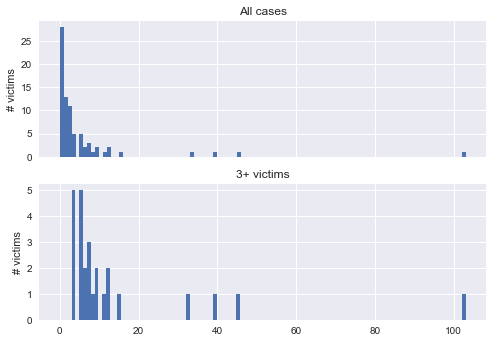

In [132]:
# take only the cases from stage 2, and drop 9/11
gtd2_us = us[(us.iyear > 1997) & (us.nvictims < 1000)]
print(gtd2_us.nvictims.max())
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.hist([int(i) for i in gtd2_us.nvictims.values if not np.isnan(i)], bins=103);
ax1.set_title('All cases')
ax1.set_ylabel('# victims')
ax2.hist([int(i) for i in gtd2_us.nvictims.values if (not np.isnan(i)) and (i > 2)], bins=103);
ax2.set_title('3+ victims')
ax2.set_ylabel('# victims')

print(gtd2_us[gtd2_us.nvictims >= 3].shape)
gtd2_us_3pv = gtd2_us[gtd2_us.nvictims >= 3]

In [133]:
gtd2_us_3pv.to_csv('/Users/dcard/Desktop/temp.csv')
gtd2_us_3pv.head(n=25)

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,nvictims
67898,199807240001,1998,7,24,NaN,0,NaN,217,United States,1,North America,District of Columbia,Washington,38.890370,-77.031959,1.0,0,NaN,"07/24/1998: An individual, Russell Weston, was...",1,1,1,0,NaN,NaN,0,1,0,2,Armed Assault,NaN,NaN,NaN,NaN,2,Government (General),21.0,Government Building/Facility/Office,United States Legislature,The U.S. Capitol Building in Washington D.C.,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,Unknown,0.0,NaN,NaN,1,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,Firearms,3.0,Handgun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A .38-caliber gun was used in the attack.,2.0,2.0,0.0,1.0,1.0,0.0,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Police shot in US Capitol building, Leiceste...","David Epso, Two Capitol policemen killed in f...","Jason Strait, Report: Suspect Suspicious of F...",CETIS,-9,-9,0,-9,NaN,3.0
68742,199904200004,1999,4,20,NaN,0,NaN,217,United States,1,North America,Colorado,Littleton,39.616905,-105.014519,1.0,0,Near Littleton in unincorporated Jefferson County,04/20/1999: Two armed high school students ope...,0,1,1,1,2.0,Other Crime Type,0,1,1,6,Hostage Taking (Kidnapping),2.0,Armed Assault,NaN,NaN,8,Educational Institution,48.0,Teacher/Professor/Instructor,Civilians,Students and teachers at Columbine High School.,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,Unknown,0.0,NaN,NaN,1,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,Firearms,3.0,Handgun,5.0,Firearms,4.0,Rifle/Shotgun (non-automatic),6.0,Explosives/Bombs/Dynamite,17.0,Other Explosive Type,NaN,NaN,NaN,NaN,"The two perpetrators each had numerous guns, M...",15.0,15.0,2.0,24.0,24.0,0.0,1,4.0,Unknown,NaN,Damage was done to the school buildings from s...,1.0,56.0,56.0,4.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,6.0,Combination,46.0,NaN,"Robert Weller, 25 May Be Dead in School Shoot...",Up to 25 die in shooting at Colorado high sch...,"Ted Taylor, Chris Barker, Cox News Service, C...",CETIS,-9,-9,0,-9,NaN,39.0
69053,199907020004,1999,7,2,NaN,0,NaN,217,United States,1,North America,Illinois,Chicago,41.884150,-87.632409,1.0,0,NaN,"07/02/1999: Perpetrator, Benjamin Nathaniel Sm...",1,1,1,1,2.0,Other Crime Type,1,1,0,2,Armed Assault,NaN,NaN,NaN,NaN,14,Private Citizens & Property,69.0,Religion Identified,Jewish people,Jews attending temple.,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,World Church of the Creator,NaN,NaN,NaN,NaN

In [134]:
# take only the cases that are past the end date of MSA
gtd2_us_temp = us[(us.iyear == 2016) & (us.imonth > 6)]
print(gtd2_us_temp[gtd2_us_temp.nvictims >= 3].shape)


(4, 136)


In [110]:
print(gtd2_us_3pv.crit1.mean())
print(gtd2_us_3pv.crit2.mean())
print(gtd2_us_3pv.crit3.mean())

0.88
1.0
0.96


In [168]:
#gtd[gtd.eventid == 201502100004].head()
print(gtd[gtd.eventid == 201502100004]['addnotes'].values)

[ 'There is doubt that this incident meets terrorism-related criteria, given that it is unclear whether the assailant was motivated by Islamophobic feelings or by a parking dispute.']


In [162]:
msa[(msa.City == 'Washington')].head()

,CaseID,Title,Location,City,State,Latitude,Longitude,Number of Civilian Fatalities,Number of Civilian Injured,Number of Enforcement Fatalities,Number of Enforcement Injured,Total Number of Fatalities,Total Number of Victims,Description,Date,Day of Week,Date - Detailed,Shooter Name,Number of shooters,Shooter Age(s),Average Shooter Age,Shooter Sex,Shooter Race,Type of Gun - Detailed,Type of Gun - General,Number of Shotguns,Number of Rifles,Number of Handguns,Total Number of Guns,Number of Automatic Guns,Number of Semi-Automatic Guns,Fate of Shooter at the scene,Fate of Shooter,Shooter's Cause of Death,School Related,Place Type,Relationship to Incident Location,Targeted Victim/s - Detailed,Targeted Victim/s - General,Possible Motive - Detailed,Possible Motive - General,History of Mental Illness - Detailed,History of Mental Illness - General,Data Source 1,Data Source 2,Data Source 3,Data Source 4,Data Source 5,Data Source 6,Data Source 7,Military Experience,Class,Depreciation,Notes,Edit Date,iyear,imonth,iday
148,149,Washington Navy Yard,Washington D.C.,Washington,District of Columbia,38.904809,-77.016297,12,2,0,1,13,15,"On September 16, 2013, a 34-yearl old contract...",9/16/2013,Monday,"Monday, September 16, 2013",Aaron Alexis,1,34,34,Male,Black American or African American,"Remington 870 shotgun, Beretta handgun",Multiple guns,1,0,1,2,0,1,Deceased,Deceased,Killed,No,Military facility,Place of business/employment,Military and coworkers at the Navy Yar. Accord...,Colleague/Workmate/Business acquaintance,The shooter is said to have delusional theorie...,Mental illness,There are multiple indicators that the shooter...,Yes,http://www.fbi.gov/news/navy-yard-shootings-in...,http://www.fbi.gov/washingtondc/press-releases...,http://www.newyorker.com/online/blogs/newsdesk...,http://www.nytimes.com/2013/09/18/us/washingto...,http://bigstory.ap.org/article/13-killed-washi...,http://www.usatoday.com/story/news/2015/07/02/...,https://en.wikipedia.org/wiki/Washington_Navy_...,Yes,MS,1,NaN,6/23/2016,2013,9,16


In [50]:
# take a subset of events from GTD that are specified as taking place in the United States
#gtd_us = gtd[gtd['country_txt'] == 'United States']
#gtd_us.shape


(2758, 135)

In [51]:
# do the same for the RAND database
rand_us = rand[rand['Country'] == 'United States']
rand_us.shape


(567, 11)

In [70]:
# create a new database to hold the merged records
df_merged = pd.DataFrame(columns=['iyear', 'imonth', 'iday', 'City', 'Country', 'rand', 'gtd', 'n_matches'])
count = 0
# look through every event in the RAND database
for i in rand_us.index:
    # extract the year, month, day, city, and description
    year = rand_us.loc[i, 'iyear']
    month = rand_us.loc[i, 'imonth']
    day = rand_us.loc[i, 'iday']
    city = str(rand_us.loc[i, 'City'])
    rand_desc = str(rand_us.loc[i, 'Description'])
    # exclude those that don't specify a city
    if city != 'nan':
        # correct for naming conventions
        if city == 'Washington, D.C.' or city == 'Washington, DC':
            city = 'Washington'
        # look for records in GTD with the same year, month, day, and city
        matches = gtd_us[(gtd_us['iyear'] == year) & (gtd_us['imonth'] == month) & (gtd_us['iday'] == day) & (gtd_us['city'] == city)]
        # if there is at least one match, store the first one, and note how many matches there were
        if len(matches) > 0:
            n_matches = len(matches.index)
            first_match = matches.index[0]
            gtd_desc = matches.loc[first_match, 'summary']
            # add the merged record to the new DataFrame
            df_merged.loc[count] = [year, month, day, city, 'United States', rand_desc, gtd_desc, n_matches]
            count += 1
    

In [71]:
# see how many merged events we found
df_merged.shape

(323, 8)

In [73]:
# look at the distribution of the number of matches 
np.bincount(np.array(df_merged['n_matches'], dtype=int))


array([  0, 254,  44,   5,  18,   2])

In [ ]:
# most (254) are matching to a unique event in GTD

In [63]:
# print a list of city values in the GTD to look for weird names
set(gtd_us['city'].values)

{'Afton',
 'Aguada',
 'Aguadilla',
 'Aibonito',
 'Akron',
 'Alameda',
 'Alamogordo',
 'Albany',
 'Albertville',
 'Albion',
 'Albuquerque',
 'Alexandria',
 'Alhambra',
 'Altadena',
 'Alton',
 'Amarillo',
 'Ames',
 'Amherst',
 'Anaheim',
 'Anamosa',
 'Ann Arbor',
 'Annapolis',
 'Appleton',
 'Aptos',
 'Arcata',
 'Arecibo',
 'Arivaca',
 'Arlington',
 'Asbury',
 'Asheville',
 'Ashland',
 'Ashville',
 'Astoria',
 'Athens',
 'Atherton',
 'Atlanta',
 'Auburn',
 'Augusta',
 'Aurora',
 'Austin',
 'Axton',
 "Bailey's Crossroads",
 'Bakersfield',
 'Baltimore',
 'Baraboo',
 'Barnegat',
 'Batavia',
 'Baton Rouge',
 'Baxter Springs',
 'Bayamon',
 'Beaumont',
 'Bedford Park',
 'Bel Air',
 'Bellevue',
 'Bellflower',
 'Bellingham',
 'Belmont',
 'Ben Lomond',
 'Bend',
 'Berkeley',
 'Berlin',
 'Bessemer',
 'Bethesda',
 'Beverly Hills',
 'Biggsville',
 'Billings',
 'Birmingham',
 'Blooming Grove',
 'Bloomington',
 'Bluefield',
 'Boca Raton',
 'Boise',
 'Bonners Ferry',
 'Borinquen',
 'Boston',
 'Boulder',


In [64]:
# do the same for RAND
set(rand_us['City'].values)

{'Albany',
 'Albertville',
 'Albuquerque',
 'Alhambra',
 'Anaheim',
 'Astoria',
 'Atlanta',
 'Auburn',
 'Austin',
 'Baltimore',
 'Bellingham',
 'Berkeley',
 'Bethesda',
 'Birmingham',
 'Bloomington',
 'Boca Raton',
 'Boston',
 'Cambridge',
 'Charlottesville',
 'Chicago',
 'Chico',
 'Clatskanie',
 'Coral Gables',
 'De Kalb',
 'Dearborn',
 'Detroit',
 'East Lansing',
 'Elizabeth',
 'Ellettsville',
 'Emeryville',
 'Erie',
 'Estacada',
 'Eugene',
 'Falls Church Virginia',
 'Fargo',
 'Fort Lauderdale',
 'Fresno',
 'Ft. Hood',
 'Galveston',
 'Garden Grove',
 'Girard',
 'Glen Cove',
 'Glendale',
 'Granada Hills',
 'Grangeville, Idaho',
 'Greenville',
 'Hagerstown',
 'Hialeah',
 'Hoboken',
 'Hollywood',
 'Houghton, Michigan',
 'Houston',
 'Irvine',
 'Jacksonville',
 'Key Biscayne',
 'Key West',
 'Laguna Woods',
 'Langley',
 'Leavenworth',
 'Lincoln',
 'Little Rock',
 'Long Island',
 'Los Angeles',
 'Martiny',
 'Medford',
 'Miami',
 'Middle Island',
 'Miller Place',
 'Minneapolis',
 'Monmouth',

In [3]:
# from a quick glance, only Washington DC needs extra care

In [10]:
# look at a snapshot of the RAND database
rand.head()

,Date,City,Country,Perpetrator,Weapon,Injuries,Fatalities,Description
0,1-May-73,Kabul,Afghanistan,Black December,Firearms,0,0,AFGHANISTAN. A member of the Pakistani Black ...
1,14-Feb-79,Kabul,Afghanistan,Other,Firearms,0,1,AFGHANISTAN. The U.S. Ambassador to Afghanis...
2,7-Sep-79,Kabul,Afghanistan,Unknown,Firearms,0,6,AFGHANISTAN. Six West Germans were shot and k...
3,8-Sep-79,Kabul,Afghanistan,Unknown,Unknown,1,0,"AFGHANISTAN. Lt. Col. Michael Cavanaugh, a U...."
4,9-Sep-79,NaN,Afghanistan,Other,Firearms,1,2,AFGHANISTAN. Afghanistan rebels ambushed a to...


In [48]:
# convert the dates in the RAND database to year, month, day
from datetime import datetime
datetimes = [pd.to_datetime(d) for d in rand['Date']]
years = [d.year for d in datetimes]
months = np.array([d.month for d in datetimes], dtype=int)
days = np.array([d.day for d in datetimes], dtype=int)
rand['iyear'] = years
rand['imonth'] = months
rand['iday'] = days
rand.head()

,Date,City,Country,Perpetrator,Weapon,Injuries,Fatalities,Description,iyear,imonth,iday
0,1-May-73,Kabul,Afghanistan,Black December,Firearms,0,0,AFGHANISTAN. A member of the Pakistani Black ...,1973,5,1
1,14-Feb-79,Kabul,Afghanistan,Other,Firearms,0,1,AFGHANISTAN. The U.S. Ambassador to Afghanis...,1979,2,14
2,7-Sep-79,Kabul,Afghanistan,Unknown,Firearms,0,6,AFGHANISTAN. Six West Germans were shot and k...,1979,9,7
3,8-Sep-79,Kabul,Afghanistan,Unknown,Unknown,1,0,"AFGHANISTAN. Lt. Col. Michael Cavanaugh, a U....",1979,9,8
4,9-Sep-79,NaN,Afghanistan,Other,Firearms,1,2,AFGHANISTAN. Afghanistan rebels ambushed a to...,1979,9,9
